# Star Craft classification from disk 
The objective of this guide is to show how to train a model from disk using keras. This is useful if your training or testing set is numerous and you just can not have a numpy array with all the values.  

In addition you will see:  
* Convolutional Neural Networks
* Save a model 

The origin of the images can be found here **[1]**. 
  
* [1]http://starcraft.wikia.com/wiki/List_of_StarCraft_II_units  


In [85]:
import os
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.models import load_model

show the files in the current location

In [1]:
#First get the data
!ls

${f}							SC2Units
get_images_from_sc2_html				SC2UnitsByRace.zip
Keras - StarCraft Unit Classification from disk.ipynb	sc2_units_files
Keras - StarCraft unit prediction from disk - FC.ipynb	sc2_units.html
notes							SC2Units.zip
README.md


We will work with the zip file **SC2UnitsByRace.zip**. This zip File contains a folder with the following structure:  
* SC2Units/
* SC2Units/Protoss/
* SC2Units/Zerg/
* SC2Units/Terran/  
Inside each of them there are images that correspond to those classes. 

In [4]:
zf = 'SC2UnitsByRace.zip'

#To see the content of the zip file we list its content with the printdir() function.
tz = zipfile.ZipFile(zf)
tz.printdir()
tz.close()

File Name                                             Modified             Size
SC2Units/                                      2018-04-19 09:27:32            0
SC2Units/Protoss/                              2018-04-19 09:26:54            0
SC2Units/Protoss/Icon_Protoss_High_Templar.jpg 2018-04-18 17:10:20         5513
SC2Units/Protoss/Icon_Protoss_Cybernetics_Core.jpg 2018-04-18 17:10:28         5002
SC2Units/Protoss/Icon_Protoss_Sentry.jpg       2018-04-18 17:10:24         5574
SC2Units/Protoss/Icon_Protoss_Templar_Archives.jpg 2018-04-18 17:10:34         4544
SC2Units/Protoss/Icon_Protoss_Phoenix.jpg      2018-04-18 17:10:22         4471
SC2Units/Protoss/Icon_Protoss_Oracle.jpg       2018-04-18 17:10:36         6254
SC2Units/Protoss/Icon_Protoss_Photon_Cannon.jpg 2018-04-18 17:10:30         5094
SC2Units/Protoss/Icon_Protoss_Dark_Shrine.jpg  2018-04-18 17:10:28         3521
SC2Units/Protoss/Icon_Protoss_Mothership.jpg   2018-04-18 17:10:22         7162
SC2Units/Protoss/Icon_Protoss_R

Now we will create a Dataframe that will have in one column the location to the images and in another a vector, **hot encoding**, for the three races.  
For this purposes the last folder to the right in each file name will represent the class

In [25]:
target_col = 'target' #target_class_column_name
file_col = 'file' #file_location_column_name
hot_key_col = 'y_col' #Column that will hold the hot key encoding

list_to_df = []
tz = zipfile.ZipFile(zf)
for file in tz.namelist():
    if "jpg" in file:
        list_to_df.append({file_col:file,target_col:file.split('/')[-2]})
tz.close()
location_df = pd.DataFrame(list_to_df)
print("New DataFrame:\n",location_df.head(3))


New DataFrame:
                                                 file   target
0     SC2Units/Protoss/Icon_Protoss_High_Templar.jpg  Protoss
1  SC2Units/Protoss/Icon_Protoss_Cybernetics_Core...  Protoss
2           SC2Units/Protoss/Icon_Protoss_Sentry.jpg  Protoss


Now we define the hot enconding manually. We could use pandas to_dummies function too.  
Nonetheless, I like to keep track of the conversion.  


In [28]:

def get_hot_key_dic(idf,class_column_name):
    unique_classes = list(idf[class_column_name].unique())
    hot_key_len = len(unique_classes)
    hot_key_dic = {}
    for _,class_name in enumerate(unique_classes):
        hot_key_vec = np.zeros([1,hot_key_len])
        hot_key_vec[0,_]=1
        hot_key_dic[class_name]=hot_key_vec
    return hot_key_dic.copy()

hkd = get_hot_key_dic(location_df,target_col)
print("Hot key dictionary:\n",hkd,"\n")

#Now create a column with the hot enconding
location_df[hot_key_col] = location_df[target_col].apply(lambda x: hkd[x])

print("DataFrame with hot key encoding:\n",location_df.head(3))

Hot key dictionary:
 {'Zerg': array([[0., 1., 0.]]), 'Protoss': array([[1., 0., 0.]]), 'Terran': array([[0., 0., 1.]])} 

DataFrame with hot key encoding:
                                                 file   target  \
0     SC2Units/Protoss/Icon_Protoss_High_Templar.jpg  Protoss   
1  SC2Units/Protoss/Icon_Protoss_Cybernetics_Core...  Protoss   
2           SC2Units/Protoss/Icon_Protoss_Sentry.jpg  Protoss   

               y_col  
0  [[1.0, 0.0, 0.0]]  
1  [[1.0, 0.0, 0.0]]  
2  [[1.0, 0.0, 0.0]]  


### Split the dataframe into training and testing

In [38]:
def split_df(idf,train_percentage=0.8,shuffle=True,v=False):
    """
    idf: input Dataframe 
    train_percentage: Perentage of the dataframe that the training set will have.
    shuffle: Tell whether shuffle before the split
    v: Verbosity, if True print results log.
    """
    tdf = idf.sample(frac=1).reset_index()
    rows = tdf.shape[0]
    train_rows = int(rows*train_percentage)
    test_rows = rows - train_rows
    _train_df = tdf.head(train_rows)
    _test_df = tdf.tail(test_rows)
    if v==True:
        print(_train_df.shape,_test_df.shape)
    return _train_df,_test_df

train_df,test_df = split_df(location_df,train_percentage=0.8,v=True)

#Validate if it is working:
show_samples=2
print("Train "+str(show_samples)+" samples:\n",train_df.head(show_samples),"\n")
print("Test "+str(show_samples)+" samples:\n",test_df.head(show_samples))

(88, 4) (22, 4)
Train 2 samples:
    index                                          file  target  \
0     76    SC2Units/Terran/Hellbat_SC2-HotS_Icon1.jpg  Terran   
1    108  SC2Units/Terran/EngineeringBay_SC2_Icon1.jpg  Terran   

               y_col  
0  [[0.0, 0.0, 1.0]]  
1  [[0.0, 0.0, 1.0]]   

Test 2 samples:
     index                                       file target              y_col
88     72       SC2Units/Zerg/Icon_Zerg_Mutalisk.jpg   Zerg  [[0.0, 1.0, 0.0]]
89     64  SC2Units/Zerg/Icon_Zerg_Greater_Spire.jpg   Zerg  [[0.0, 1.0, 0.0]]


We create a function to load an image from a file location and in addition we resize it to a shape **(64,64)**.

(32, 32, 3)


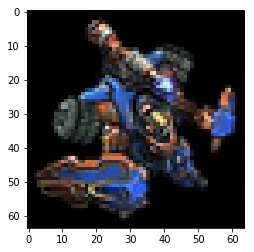

In [61]:
def zip_image_file_to_np(file_name,image_func,zip_file,image_func_kargs):
    with zipfile.ZipFile(zip_file) as tz:
        with tz.open(file_name) as f:
            return image_func(f,**image_func_kargs)

def image_file_to_np(ifile,resize=(64,64),batch_shape=False):
    """
    Will return a numpy array.
    resize: specify the resize of the image so you could fix a shape for your images.
    batch_shape: Normal output will be a numpy array of shape (width, Height , 3).
     if batch_shape is set to True, the shape will be (1, width, Height , 3). Useful for batch processing.
    """
    pil_img = Image.open(ifile)
    pil_img = pil_img.resize(resize,Image.ANTIALIAS)
    np_img = np.asarray(pil_img)
    pil_img.close()
    if batch_shape==True:
        nps = list(np_img.shape)
        nps.insert(0,1)
        np_img = np_img.reshape(nps)
    return np_img.copy()

#zf is the variable that holds the zip file.
test_img = train_df['file'][0]
test_img = zip_image_file_to_np(test_img,image_file_to_np,zf,image_func_kargs={'resize':(64,64),'batch_shape':False})
print(np_img.shape)

plt.imshow(test_img)
plt.show()

Next, we define a function that will use the numpy image and extract some features. In this case a histogram for the three channels, and will concatenate one after the other. The number of bars is represented by the variable **bins**.

## Create a function to create batches from disk  
We need to load the content according to the mini-batch size, so the previous functions of loading a numpy array from disk and extracting a histogram must be called only for a batch. 

In [77]:
def batch_proc_from_df(idf,x_func,x_func_kargs,x_col='file',y_col='target',batch_size=4,offset=4):
    """
    This function will extract a batch of size *batch_size* starting at the poing *offset*
    of the dataframe *idf*. Then the values from the column *x_col* will be processed by transformed 
    using the function *x_func*. The setup parameters of the *x_func* function are specified in 
    *x_func_kargs*. 
    The values of the *y_col* column of the *idf* will be stacked vertically and returned.
    """
    start_index = offset
    rows = idf.shape[0]
    if start_index >= rows:
        start_index = start_index%rows
    end_index = start_index + batch_size
    
    if end_index>rows:
        end_index = rows
    
    tdf = idf.iloc[start_index:end_index]
    _y = np.vstack(tdf[y_col])
    
    arrays = list(map(lambda x: x_func(x,**x_func_kargs),tdf[x_col]))
    
    _x = np.vstack(arrays)
    return _x.copy(),_y.copy()

func_params={
    'image_func':image_file_to_np,
    'zip_file':zf,
    'image_func_kargs':{'resize':(64,64),'batch_shape':True}
}

xb,yb = batch_proc_from_df(train_df,zip_image_file_to_np,func_params,
                           x_col=file_col,y_col=hot_key_col,batch_size=4,offset=4)

print(xb.shape,yb.shape)


(4, 64, 64, 3) (4, 3)


### The keras model
In the keras website we find a model example [2].  

* [2]: https://keras.io/getting-started/sequential-model-guide/  

### Changing our model  
Here we have defined how many bins we want for the histogram, number of iterations (epochs), learning rate, batch-size, the resizing shape for each image.  
We use batch normalization after each fully connected layer for a better performance.

In [81]:
resize_shape=[64,64]
func_params={
    'image_func':image_file_to_np,
    'zip_file':zf,
    'image_func_kargs':{'resize':resize_shape,'batch_shape':True}
}

#Set up parameters
input_df = train_df
batch_x_func = zip_image_file_to_np
batch_x_func_params = func_params
df_x_col=file_col
df_y_col=hot_key_col

input_dims = [resize_shape[0],resize_shape[1],3]
output_classes = 3 #Terran, Protoss, Zerg
iterations = 128
learning_rate=1e-3
batch_size=8

#Model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_dims))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(output_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True))

# Iterations

rows = input_df.shape[0]
batches = int(np.ceil(rows/batch_size))

for iterx in range(iterations):
    for batch in range(batches):
        offset = batch*batch_size
        xb,yb = batch_proc_from_df(input_df,batch_x_func,batch_x_func_params,
                           x_col=df_x_col,y_col=df_y_col,batch_size=batch_size,offset=offset)
        loss = model.train_on_batch(xb, yb)
        print("Iter",iterx,"/",iterations,"Batch",batch,"/",batches,"Loss:",loss)


Iter 0 / 128 Batch 0 / 11 Loss: 2.080329
Iter 0 / 128 Batch 1 / 11 Loss: 1.7729788
Iter 0 / 128 Batch 2 / 11 Loss: 1.3560543
Iter 0 / 128 Batch 3 / 11 Loss: 1.4980118
Iter 0 / 128 Batch 4 / 11 Loss: 1.0883739
Iter 0 / 128 Batch 5 / 11 Loss: 2.0776749
Iter 0 / 128 Batch 6 / 11 Loss: 1.5172718
Iter 0 / 128 Batch 7 / 11 Loss: 1.9306554
Iter 0 / 128 Batch 8 / 11 Loss: 1.5628343
Iter 0 / 128 Batch 9 / 11 Loss: 1.2856245
Iter 0 / 128 Batch 10 / 11 Loss: 1.42596
Iter 1 / 128 Batch 0 / 11 Loss: 1.4723729
Iter 1 / 128 Batch 1 / 11 Loss: 1.1237562
Iter 1 / 128 Batch 2 / 11 Loss: 2.0861871
Iter 1 / 128 Batch 3 / 11 Loss: 0.75791764
Iter 1 / 128 Batch 4 / 11 Loss: 1.2064581
Iter 1 / 128 Batch 5 / 11 Loss: 0.9402886
Iter 1 / 128 Batch 6 / 11 Loss: 1.6349444
Iter 1 / 128 Batch 7 / 11 Loss: 0.7002928
Iter 1 / 128 Batch 8 / 11 Loss: 0.6238731
Iter 1 / 128 Batch 9 / 11 Loss: 0.860409
Iter 1 / 128 Batch 10 / 11 Loss: 1.0814195
Iter 2 / 128 Batch 0 / 11 Loss: 1.3730533
Iter 2 / 128 Batch 1 / 11 Loss: 0.7

### Test our model in the testing set  
Now, we define our batch testing using the testing set. Since the **predict** or **evaluate ** functions of the model keras doesn't have the metrics parameter, we calculate the accuracy manually.

In [96]:
def test_model(idf,keras_model):
    test_rows = idf.shape[0]
    tbatches = int(np.ceil(test_rows/batch_size))
    general_accuracy = []
    for batch in range(tbatches):
        offset = batch*batch_size
        xb,yb = batch_proc_from_df(idf,batch_x_func,batch_x_func_params,
                           x_col=df_x_col,y_col=df_y_col,batch_size=batch_size,offset=offset)
    
        classes = keras_model.predict(xb)
        loss = keras_model.evaluate(xb, yb,verbose=0)
    
        class_pred = np.argmax(classes,1)
        
        print("Batch",batch,"/",tbatches,"Loss:",loss)
        ground_truth = np.argmax(yb,1)

        accuracy = sum(np.equal(class_pred,ground_truth))/batch_size
        general_accuracy.append(accuracy)    

    print("Total accuracy",np.mean(general_accuracy))

test_model(test_df,model)

### Save the model

In [89]:
model_name='sc2_cnn.h5'

model.save(model_name)  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model


In [86]:
modelx = load_model(model_name)
test_model(test_df,keras_model=modelx)

Batch 0 / 3 Loss: 0.2925415635108948
Batch 1 / 3 Loss: 0.9142528772354126
Batch 2 / 3 Loss: 0.3205617368221283
Total accuracy 0.7083333333333334


In [90]:
resize_shape=[64,64]
func_params={
    'image_func':image_file_to_np,
    'zip_file':zf,
    'image_func_kargs':{'resize':resize_shape,'batch_shape':True}
}

#Set up parameters
input_df = train_df
batch_x_func = zip_image_file_to_np
batch_x_func_params = func_params
df_x_col=file_col
df_y_col=hot_key_col

iterations = 64
batch_size=8

rows = input_df.shape[0]
batches = int(np.ceil(rows/batch_size))

for iterx in range(iterations):
    for batch in range(batches):
        offset = batch*batch_size
        xb,yb = batch_proc_from_df(input_df,batch_x_func,batch_x_func_params,
                           x_col=df_x_col,y_col=df_y_col,batch_size=batch_size,offset=offset)
        loss = modelx.train_on_batch(xb, yb)
        print("Iter",iterx,"/",iterations,"Batch",batch,"/",batches,"Loss:",loss)


Iter 0 / 64 Batch 0 / 11 Loss: 0.0032971296
Iter 0 / 64 Batch 1 / 11 Loss: 0.0074045938
Iter 0 / 64 Batch 2 / 11 Loss: 0.04290335
Iter 0 / 64 Batch 3 / 11 Loss: 0.0030955374
Iter 0 / 64 Batch 4 / 11 Loss: 0.010244563
Iter 0 / 64 Batch 5 / 11 Loss: 0.0247713
Iter 0 / 64 Batch 6 / 11 Loss: 0.008359117
Iter 0 / 64 Batch 7 / 11 Loss: 0.002094245
Iter 0 / 64 Batch 8 / 11 Loss: 0.000978267
Iter 0 / 64 Batch 9 / 11 Loss: 0.010149945
Iter 0 / 64 Batch 10 / 11 Loss: 0.0041710446
Iter 1 / 64 Batch 0 / 11 Loss: 0.0013087601
Iter 1 / 64 Batch 1 / 11 Loss: 0.0031152186
Iter 1 / 64 Batch 2 / 11 Loss: 0.015789017
Iter 1 / 64 Batch 3 / 11 Loss: 0.005446627
Iter 1 / 64 Batch 4 / 11 Loss: 0.0038260755
Iter 1 / 64 Batch 5 / 11 Loss: 0.005698045
Iter 1 / 64 Batch 6 / 11 Loss: 0.00369098
Iter 1 / 64 Batch 7 / 11 Loss: 0.002388537
Iter 1 / 64 Batch 8 / 11 Loss: 0.0045649563
Iter 1 / 64 Batch 9 / 11 Loss: 0.003764973
Iter 1 / 64 Batch 10 / 11 Loss: 0.010052489
Iter 2 / 64 Batch 0 / 11 Loss: 0.00096925325
Ite

In [97]:
print("test training set")
test_model(train_df,keras_model=modelx)

print("test testing set")
test_model(test_df,keras_model=modelx)

test training set
Batch 0 / 11 Loss: 0.02864028885960579
Batch 1 / 11 Loss: 0.01135550532490015
Batch 2 / 11 Loss: 0.00039284140802919865
Batch 3 / 11 Loss: 0.051368847489356995
Batch 4 / 11 Loss: 0.0008814703905954957
Batch 5 / 11 Loss: 0.000958493328653276
Batch 6 / 11 Loss: 0.0004208873142488301
Batch 7 / 11 Loss: 0.009767487645149231
Batch 8 / 11 Loss: 0.002210453152656555
Batch 9 / 11 Loss: 0.002058537909761071
Batch 10 / 11 Loss: 0.05804501101374626
Total accuracy 1.0
test testing set
Batch 0 / 3 Loss: 0.21175697445869446
Batch 1 / 3 Loss: 0.7520488500595093
Batch 2 / 3 Loss: 0.3832610547542572
Total accuracy 0.7083333333333334
